In [1]:
%load_ext jupyternotify
import numpy as np
import pandas as pd
import glob
import pickle
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt

<IPython.core.display.Javascript object>

In [2]:
# Pickling functions used to save and load the dictionary file

def save_obj(obj, name):
    with open('dataset/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('dataset/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
# Importing UN data
data=[]
name=[]
for file_name in glob.glob('dataset/UNDP_HDI/*.csv'):
    data.append(pd.read_csv(file_name,
                             skiprows=0,
                             na_values="..",
                             na_filter=True,
                             header=1))
    name.append(file_name.split('/')[-1].split('.')[0])

# This snippet is for dealing with the format of the imported dataframes
for i in range(len(data)):
    for col in data[i].columns:
        # Drop columns containing 'Unnamed'
        if "Unnamed" in col: data[i].drop(labels=col, axis=1, inplace=True) 

In [4]:
data_train = pd.read_csv('dataset/train.csv')
data_test = pd.read_csv('dataset/test.csv')
columns_train = list(data_train.columns)

In [5]:
# Forming a complete list of all stripped entries in the Country column

full_list_dirty = set()
for i in range(len(data)):
    countries = [x for x in data[i].loc[:, 'Country'] if str(x) != 'nan']
    countries_stripped = set(map(lambda x: x.strip() , countries))
    full_list_dirty |= countries_stripped

# Filtering out non-countries in the column using
# manually found entries
entries_to_remove = set([
    'Arab States',
    'Developing Countries',
    'High human development',
    'Human Development',
    'Least Developed Countries',
    'Low human development',
    'Medium human development',
    'Organization for Economic Co-operation and Development',
    'Small Island Developing States',
    'South Asia',
    'Very high human development',
    'World',
    'East Asia and the Pacific',
    'Latin America and the Caribbean',
    'Regions',
    'Sub-Saharan Africa',
    'Europe and Central Asia',
    ])
full_list = full_list_dirty - entries_to_remove
full_list = sorted(list(full_list))
print(full_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo (Democratic Republic of the)', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini (Kingdom of)', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong, China (SAR)', '

#### This code was used to collate 74 tables from the UNDP_HDI folder into one with a structure similar to that of Contest data (train/test.csv). However, the column order is different from that of the Contest—this is rectified later in this notebook
```python
# Running takes ~ 10-15 mins

# Firstly, strip country names of spaces that somehow got in there
for i in range(len(data)):
    for j, country in enumerate(data[i].loc[:, 'Country']):
        if str(country) != 'nan':
            data[i].loc[j, 'Country'] = country.strip()

# Collating UNDP tables into one compatible for comparison with
# the Contest one (train/test.csv)

table = []
for country in full_list:
#    print(country)
    for year in range(1990, 2018+1):
        row = [year, country]
        for df, nm in zip(data, name):
            df_ = df.set_index('Country')
            if (country in df_.index.dropna()) and (str(year) in df.columns):
                row.append(df_.loc[country, str(year)])
            else:
                row.append(np.nan)
        table.append(row)

undp_collated = pd.DataFrame(table,
                             columns=['year', 'country']+name).set_index(['year','country']).sort_index()
```

The following snippet was used to save undp_collated.csv
```python
undp_collated.to_csv('dataset/undp_collated.csv', na_rep='nan')
```

In [6]:
undp_collated = pd.read_csv('dataset/undp_collated.csv',
                            na_values='nan').set_index(['year', 'country'])

#### The following code was used to get a dictionary connecting column names from the UNDP table to the Contest data, e.g., "Human Development Index" -> "Intergalactic Development Index". This was done primarily to save time and to avoid doing it manually.
```python
# WARNING!------------------------------------------------------------------------
# This code snippet is not to be run if one wants to get a map
# of columns. In that case refer to the *pickled dictionary file* in the dataset
# folder. This is due to the manual corrections present later in this block, which
# are dependant on a certain sequence of columns from UN data, which in turn
# depends on the glob order. This load order might change on your run!

# This code is kept only to record my steps. 

import re

# Function str_comp compares how similar two strings are
# based on matching words or numbers.
# It returns a value from 0 to 1 (if duplicate words are present, it could be more than 1).
# 0 means strings lstr1 and lstr2 contain completely different words
# and the larger the metric — the better similarity. 
# It's very crude, but gets the job done relatively well for my purpose. 

def str_comp(lstr1, lstr2): # lstr1 and lstr2 are strings to be compared
    
    # Forming 2 lists of words from strings, 
    # ignoring all non alphabet/number symbols.
    # filter removes unnecessary blank strings in the list
    # left by re.split.
    l1 = list(filter(None, re.split(r'\W',lstr1)))
    l2 = list(filter(None, re.split(r'\W',lstr2)))
    
    # matchings DO account for duplicate words in one or both lists of strings,
    # in which case it inflates the final metric to more than 1.
    # Ideally it should be fixed, but it works fine for comparing strings. 
    matchings = 0
    for s1 in l1:
        for s2 in l2:
            if s1.lower() == s2.lower(): matchings+=1
    return matchings/max([len(l1), len(l2)])


# Making a list containing indices to match columns between datasets
# based on the str_comp function 'metric'
col_map=[]
for i, col1 in enumerate(name):
    maxim = 0
    j_m = 0
    for j, col2 in enumerate(columns_train):
        comp = str_comp(col1,col2)
        # This part checks whether this combination of list of strings col1 and col2
        # are more similar than the previous best in this loop. It also checks
        # that the second list of strings col2 has not appeared before in
        # col_map to avoid duplicates. 
        if (comp >= maxim) and (j not in [x[1] for x in col_map]): 
            maxim = comp
            j_m = j
    col_map.append((i, j_m))

# Manually fixing mistakes made by the mapping script
# NOTE! This manual corrections may change on different loads of the data
#
# Please, use the columns dict pickle file in the dataset folder 
# for final mapping. 

corrections = {
    (37, 72): (37, 8),
    (43, 78): (43, 72),
    (56, 41): (56, 42),
    (57, 8): (57, 78),
    (10, 42): (10,41),
}

# Final list with corrections:
col_map_corr = [corrections.get(x,x) for x in col_map]

# Now it's nice and dandy
for i, j in col_map_corr:
    print(i, name[i])
    print(j, columns_train[j], '\n')
```

#### This code was used to save the pickled dict.  
```python
col_map_abs = {}
for i, j in col_map_corr:
    col_map_abs[name[i].strip()] = columns_train[j].strip()

save_obj(col_map_abs, 'column_dict_from_UN_to_Contest_format')
```

In [7]:
# Final dictionary for column names from UNDP to Contest
col_map_abs = load_obj('column_dict_from_UN_to_Contest_format')

col_map_abs

{'Education Index': 'Education Index',
 'Employment to population ratio (% ages 15 and older)': 'Employment to population ratio (% ages 15 and older)',
 'Population, ages 65 and older (millions)': 'Population, ages 65 and older (millions)',
 'Mortality rate, infant (per 1,000 live births)': 'Mortality rate, infant (per 1,000 live births)',
 'Human Development Index (HDI), female': 'Intergalactic Development Index (IDI), female',
 'Estimated gross national income per capita, female (2011 PPP$)': 'Estimated gross galactic income per capita, female',
 'Share of seats in parliament (% held by women)': 'Share of seats in senate (% held by female)',
 'Labour force participation rate (% ages 15 and older), male': 'Labour force participation rate (% ages 15 and older), male',
 'Remittances, inflows (% of GDP)': 'Remittances, inflows (% of GGP)',
 'International inbound tourists (thousands)': 'Intergalactic inbound tourists (thousands)',
 'Infants lacking immunization, measles (% of one-year-ol

In [9]:
# Get a list of unique galactic years
unique_years = data_train['galactic year'].unique()
print (unique_years)
print (unique_years.shape)

# Get a list of unique galaxy names
unique_names = data_train['galaxy'].unique()
unique_names = np.sort(unique_names)
print (unique_names[:5])
print (unique_names.shape)

# Let's map all galactic years to human years with an increment 
# of 1 year starting from year 1990

# Dictionary for replacement of galactic years with normal years.
# Year 1016064 is added to the unique_years since this year is not present
# in the train set, but it is in the test set. 
di = {val: ind+1990 for ind, val in enumerate(np.append(unique_years,
                                                     1016064))}

[ 990025  991020  992016  993012  994009  995006  996004  997002  998001
  999000 1000000 1001000 1002001 1003002 1004004 1005006 1006009 1007012
 1008016 1009020 1010025 1011030 1012036 1013042 1014049 1015056]
(26,)
['Andromeda Galaxy (M31)' 'Andromeda I' 'Andromeda II' 'Andromeda III'
 'Andromeda IX']
(181,)


In [10]:
# Preparing train and test set to compare with the UNDP dataset. I dropped some columns 
# since I believe the HDI Ranks for the year from which the original 
# Contest dataset was pulled might be different from the one in 2018

data_train_cl = data_train.replace({'galactic year':di})
data_train_cl = data_train_cl.set_index(['galactic year', 'galaxy']).drop(
    labels=
    [
        'Intergalactic Development Index (IDI), Rank',
        'Intergalactic Development Index (IDI), female, Rank',
        'Intergalactic Development Index (IDI), male, Rank',
        'y'
    ],
    axis=1)

# Same for the test set
data_test_cl = data_test.replace({'galactic year':di})
data_test_cl = data_test_cl.set_index(['galactic year', 'galaxy']).drop(
    labels=
    [
        'Intergalactic Development Index (IDI), Rank',
        'Intergalactic Development Index (IDI), female, Rank',
        'Intergalactic Development Index (IDI), male, Rank',
    ],
    axis=1)

In [11]:
# Inverse dictionary of col_map_abs: Contest column names -> UNDP column names
col_map_abs_inv = {v: k for k, v in col_map_abs.items()}

# Set undp_collated columns in the correct order
undp_order = [col_map_abs_inv.get(x) for x in data_train_cl.columns]
undp_clean = undp_collated[undp_order]

Code used to save undp_clean
```python
# Saving undp_clean
undp_clean.to_csv('dataset/undp_clean.csv', na_rep='nan')
```

Saving dataframes data_train_cl and data_test_cl
```python
# Saving 
data_train_cl.to_csv('dataset/data_train_cl.csv', na_rep='nan')
data_test_cl.to_csv('dataset/data_test_cl.csv', na_rep='nan')
```

TODO: find where to put this snippet, so that it makes sense

```python
undp_test = undp_clean.loc[data_test_cl.rename(galaxy_to_country).index]
undp_test = undp_test.drop(labels='y', axis=1)

undp_test.to_csv('dataset/undp_test.csv', na_rep='nan')
```

In [15]:
undp_clean

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Andorra                                             0.870   
     Angola                                              0.389   
...                                                        ...   
2018 Venezuela (Bolivarian Republic of)                  0.802   
     Viet Nam                                            0.851   
     Yemen                                               0.709   
     Zambia                                              0.669   
     Zimbabwe                                            0.634   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Andorra                                                 76.5   
     Angola                                                  45.3   
...                                                           ...   
2018 Venezuela (Bolivarian Republic of)                      72.1   
     Viet Nam                                                75.3   
     Yemen                                                   66.1   
     Zambia                                                  63.5   
     Zimbabwe                                                61.2   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Andorra                                                                       49062.0    
     Angola                                                                         4139.0    
...                                                                                    ...    
2018 Venezuela (Bolivarian Republic of)                                             9070.0    
     Viet Nam                                                                       6220.0    
     Yemen                                                                          1433.0    
     Zambia                                                                         3582.0    
     Zimbabwe                                                                       2661.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Andorra                                    0.936   
     Angola                                     0.562   
...                                               ...   
2018 Venezuela (Bolivarian Republic of)         0.681   
     Viet Nam                                   0.624   
     Yemen                                      0.402   
     Zambia                                     0.541   
     Zimbabwe                                   0.496   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

In [14]:
# For loading 
undp_clean = pd.read_csv('dataset/undp_clean.csv', na_values='nan').set_index(['year', 'country'])
data_train_cl = pd.read_csv('dataset/data_train_cl.csv', na_values='nan').set_index(['galactic year', 'galaxy'])

In [16]:
# Define some variables
data_train_cl_no_world = data_train_cl.drop(labels='NGC 1560', axis=0, level=1)
data_test_cl_no_world = data_test_cl.drop(labels='NGC 1560', axis=0, level=1)
data_full_cl_no_world = data_test_cl_no_world.append(data_train_cl_no_world).sort_index()

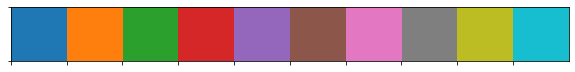

In [17]:
sns.palplot(sns.color_palette())

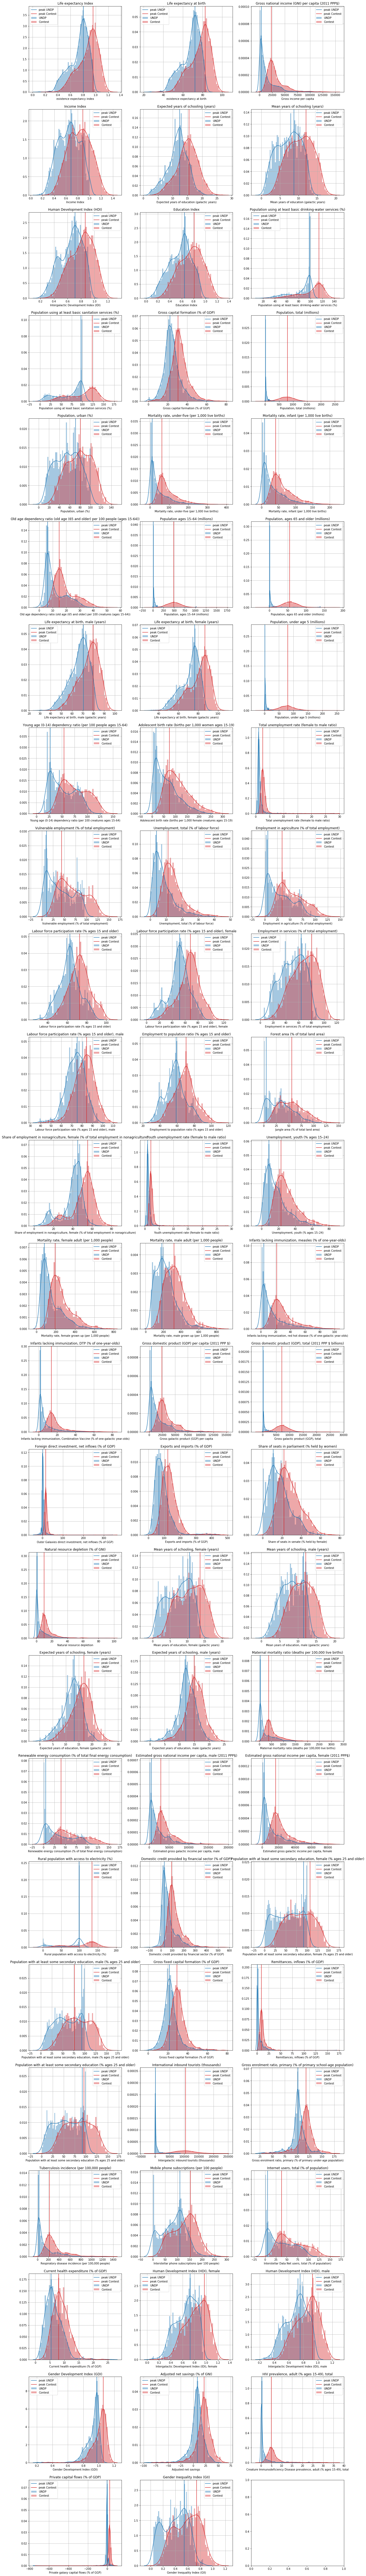

In [18]:
# Plots of UNDP attributes vs Contest attributes
from scipy.stats import gaussian_kde

# Seaborn default palette
colors = sns.color_palette()

# Slice undp_clean to keep years up until 2016
idx = pd.IndexSlice
undp_reduced = undp_clean.loc[idx[1990:2016, :],]

# List to keep track of peak1 and peak2 — modes of distributions
peaks = []

fig, axes = plt.subplots(25, 3, figsize=(21, 7*25))
for i in range(len(undp_reduced.columns)):
    ax = axes[i // 3, i % 3]
    hist1 = sns.distplot(undp_reduced.iloc[:, i], color=colors[0], label='UNDP', bins=50, ax=ax)
    hist2 = sns.distplot(data_full_cl_no_world.iloc[:, i], color=colors[3],  label='Contest', bins=50, ax=ax)
# Estimating modes of distributions yielded by KDE
    kde1 = gaussian_kde(undp_reduced.iloc[:, i].dropna(), bw_method='scott')
    kde2 = gaussian_kde(data_full_cl_no_world.iloc[:, i].dropna(), bw_method='scott')
    
    x1 = np.linspace(undp_reduced.iloc[:, i].dropna().min(),
                    undp_reduced.iloc[:, i].dropna().max(),
                    num=1000)
    x2 = np.linspace(data_full_cl_no_world.iloc[:, i].dropna().min(),
                    data_full_cl_no_world.iloc[:, i].dropna().max(),
                    num=1000)
    peak1 = x1[np.argmax(kde1.pdf(x1))]
    peak2 = x2[np.argmax(kde2.pdf(x2))]
    peaks.append((peak1, peak2))
    ax.axvline(x=peak1, color=colors[0], ls='-', label='peak UNDP')
    ax.axvline(x=peak2, color=colors[3], ls='-', label='peak Contest')

    
#    sns.distplot(undp_reduced.iloc[:, i] + peak2 - peak1, color=colors[2], label='Shifted UNDP', bins=50, ax=ax)
#     ax.axvline(x=undp_reduced.iloc[:, i].mean(), color=colors[0], ls='--', label='UNDP mean')
#     ax.axvline(x=data_full_cl_no_world.iloc[:, i].mean(), color=colors[1], ls='--', label='Contest mean')
#   ax.axvline(x=undp_reduced.iloc[:, i].mean() + 0.25*undp_reduced.iloc[:, i].median(), color=colors[2], ls='--')

    ax.grid()
    ax.title.set_text(undp_reduced.columns[i])
    ax.legend()

# print('blue std =', np.std(undp_reduced.iloc[:, i]))
# print('blue mean =', undp_reduced.iloc[:, i].mean())
# print('blue median =', undp_reduced.iloc[:, i].median())
# print('blue min =', undp_reduced.iloc[:, i].min())
# print('blue max =', undp_reduced.iloc[:, i].max(), '\n')

# print('red std =', np.std(data_full_cl_no_world.iloc[:, i]))
# print('red mean =', data_full_cl_no_world.iloc[:, i].mean())
# print('red median =', data_full_cl_no_world.iloc[:, i].median())
# print('red min =', data_full_cl_no_world.iloc[:, i].min())
# print('red max =', data_full_cl_no_world.iloc[:, i].max())

## Attempts at implementing a pairwise distance calculation

In [288]:
undp_clean.groupby(level=1)['Gross national income (GNI) per capita (2011 PPP$)'].mean().sort_values().tail(10)

country
Luxembourg                              70483.379310
Kuwait                                  82010.068966
Brunei Darussalam                       82474.758621
Liechtenstein                           84774.551724
United Arab Emirates                    86467.827586
Qatar                                  100280.793103
Korea (Democratic People's Rep. of)              NaN
Monaco                                           NaN
San Marino                                       NaN
Somalia                                          NaN
Name: Gross national income (GNI) per capita (2011 PPP$), dtype: float64

In [286]:
data_train_cl_no_world.groupby(level=1)['Gross income per capita'].mean().sort_values().tail(10)

galaxy
NGC 4163 (NGC 4167)                61913.313908
NGC 5237                           64935.709143
MB 3                               67788.660471
KK98 35                            71319.805602
ESO 294-010                        73737.109766
Tucana Dwarf                       88805.521680
Perseus I (Andromeda XXXIII)       98798.934029
Ursa Minor Dwarf                  102608.503189
Holmberg II (DDO 50, UGC 4305)    110196.993692
KKh 086                           114590.972203
Name: Gross income per capita, dtype: float64

In [187]:
undp_clean[undp_clean['Population, total (millions)']>300]['Population, total (millions)']

year  country      
1990  China            1176.9
      India             873.3
1995  China            1240.9
      India             963.9
2000  China            1290.6
      India            1056.6
2005  China            1330.8
      India            1147.6
2010  China            1368.8
      India            1234.3
      United States     309.0
2011  China            1376.5
      India            1250.3
      United States     311.6
2012  China            1384.2
      India            1265.8
      United States     314.0
2013  China            1391.9
      India            1280.8
      United States     316.4
2014  China            1399.5
      India            1295.6
      United States     318.7
2015  China            1406.8
      India            1310.2
      United States     320.9
2016  China            1414.0
      India            1324.5
      United States     323.0
2017  China            1421.0
      India            1338.7
      United States     325.1
2018  China         

In [205]:
data_train_cl_no_world[data_train_cl_no_world['Population, total (millions)']>1500]

existence expectancy index  \
galactic year galaxy                                                      
1990          Andromeda XXVI                                   0.678498   
              Phoenix II                                       0.952909   
1995          Phoenix II                                       0.922333   
2000          Phoenix II                                       0.946343   
              Andromeda XXVI                                   0.839765   
2005          Phoenix II                                       0.975695   
              Andromeda XXVI                                   0.765746   
2010          Andromeda XX                                     1.008997   
2011          Sagittarius Dwarf Sphr SagDEG                    0.976631   
2013          Phoenix II                                       1.036667   
2014          Phoenix II                                       0.904959   
2015          Andromeda XXVI                                   0.850204   

                                             existence expectancy at birth  \
galactic year galaxy                                                         
1990          Andromeda XXVI                                     60.160352   
              Phoenix II                                         75.959963   
1995          Phoenix II                                         78.393923   
2000          Phoenix II                                         81.020079   
              Andromeda XXVI                                     73.409512   
2005          Phoenix II                                         88.841210   
              Andromeda XXVI                                     72.233407   
2010          Andromeda XX                                       80.078686   
2011          Sagittarius Dwarf Sphr SagDEG                      85.091917   
2013          Phoenix II                                         80.686026   
2014          Phoenix II                                         86.354594   
2015          Andromeda XXVI                                     78.826137   

                                             Gross income per capita  \
galactic year galaxy                                                   
1990          Andromeda XXVI                            15190.567130   
              Phoenix II                                26557.505620   
1995          Phoenix II                                10169.550893   
2000          Phoenix II                                26436.072777   
              Andromeda XXVI                            14578.189439   
2005          Phoenix II                                21438.092977   
              Andromeda XXVI                            31000.310747   
2010          Andromeda XX                              19704.676733   
2011          Sagittarius Dwarf Sphr SagDEG             34884.177526   
2013          Phoenix II                                34878.720462   
2014          Phoenix II                                30703.894330   
2015          Andromeda XXVI                            14153.047087   

                                             Income Index  \
galactic year galaxy                                        
1990          Andromeda XXVI                     0.582529   
              Phoenix II                         0.600758   
1995          Phoenix II                         0.630508   
2000          Phoenix II                         0.687468   
              Andromeda XXVI                     0.721789   
2005          Phoenix II                         0.887763   
              Andromeda XXVI                     0.743089   
2010          Andromeda XX                       0.583766   
2011          Sagittarius Dwarf Sphr SagDEG      0.922887   
2013          Phoenix II                         0.969781   
2014          Phoenix II                         0.859733   
2015          Andromeda XXVI                     0.813188   

                                     

## This where the magic happens. Determining the mapping of galaxies

In [19]:
# # L1 Pairwise distance (Manhattan) between means of galaxies and countries
# # Takes about 10 mins to complete.
# # This can be largely optimized with a more proper usage of vectorization
# # capabilities of the pandas package. For now, this will suffice.

# # Calculate shifts for columns using peak coordinates of distributions
# shift = [p2-p1 for p1, p2 in peaks]
# shift = np.array(shift)
# # Contest dataset train+test accounting for shift
# contest_comp = data_full_cl_no_world - shift
# galaxies = contest_comp.index.levels[1]
# countries = undp_clean.index.levels[1]
# # Vector of means
# means = np.array(undp_clean.mean(axis=0))
# #medians = undp_clean.median(axis=0)

# table=[]
# for galaxy in galaxies:
# #    print(galaxy)
#     gal_slice = contest_comp.loc[idx[:, galaxy],]
#     years_to_comp = [year for year, gal in gal_slice.index]
#     gal_vect = gal_slice.mean(axis=0)
#     row=[]
#     for country in countries:
#         country_slice = undp_clean.loc[idx[years_to_comp, country],]
#         country_vect = country_slice.mean(axis=0)
#         # Vector of differences in units of mean of the column
#         diff_vect = (np.array(gal_vect) - np.array(country_vect)) / means
#         # Drop NaN
#         diff_vect = diff_vect[~(np.isnan(diff_vect))]
#         # Calculating Manhattan norm
#         row.append(np.abs(diff_vect).sum())
#     table.append(row)

In [387]:
# Pairs based on similar NaN distribution
pairs = []

# Calculate shifts for columns using peak coordinates of distributions
shift = [p2-p1 for p1, p2 in peaks]
shift = np.array(shift)
# Contest dataset train+test accounting for shift
contest_comp = data_full_cl_no_world - shift

# Drop the all-NaN rows in the Contest data
nan_gals = ['ESO 383-087 (ISG 39)',
            'NGC 247',
            'ESO 325-11',
            'ESO 540-032',
            'KK98 77'
           ]
contest_comp_without_5 = contest_comp
for x in nan_gals:
    contest_comp_without_5 = contest_comp_without_5.drop(labels=idx[2016, x])


galaxies = contest_comp.index.levels[1]
countries = undp_clean.index.levels[1]

for galaxy in galaxies:
    gal_slice = contest_comp_without_5.loc[idx[:, galaxy],]
    years_to_comp = [year for year, gal in gal_slice.index]
    suitable_countries = []
    for country in countries:
        country_slice = undp_clean.loc[idx[years_to_comp, country],]
        
        
        if np.equal(country_slice.isna().values,
                    gal_slice.isna().values).sum()/gal_slice.isna().values.size == 1: 
            suitable_countries.append(country)
    pairs.append(suitable_countries)

In [433]:
# Using L1 Pairwise distance (Manhattan) between means of 
# galaxies and countries to improve the result of 'pairs'

# Calculate shifts for columns using peak coordinates of distributions
shift = [p2-p1 for p1, p2 in peaks]
shift = np.array(shift)
# Contest dataset train+test accounting for shift
contest_comp = data_full_cl_no_world - shift
galaxies = contest_comp.index.levels[1]
countries = undp_clean.index.levels[1]
# Vector of means
means = np.array(undp_clean.mean(axis=0))
#medians = undp_clean.median(axis=0)

gal_to_country = []
for galaxy, country_list in zip(galaxies, pairs):
    if len(country_list) != 1:
        gal_slice = contest_comp.loc[idx[:, galaxy],]
        years_to_comp = [year for year, gal in gal_slice.index]
        gal_vect = gal_slice.mean(axis=0)
        diffs = []
        for country in country_list:
            country_slice = undp_clean.loc[idx[years_to_comp, country],]
            country_vect = country_slice.mean(axis=0)
            # Vector of differences in units of mean of the column
            diff_vect = (np.array(gal_vect) - np.array(country_vect)) / means
            # Drop NaN
            diff_vect = diff_vect[~(np.isnan(diff_vect))]
            # Calculating Manhattan norm
            diffs.append(np.abs(diff_vect).sum())
        results = sorted(list(zip(diffs, country_list)))
        print (results)
        gal_to_country.append([galaxy, results[0][-1]])
    else: gal_to_country.append([galaxy, country_list[0]])
gal_to_country.append(['NGC 1560', 'World'])

[(22.411629311624978, 'Israel'), (35.342959060267276, 'Sweden'), (39.618875850929335, 'Switzerland')]
[(25.293588434130143, 'Indonesia'), (45.09128737341403, 'Mexico'), (54.97447186564967, 'Tunisia')]
[(21.016530655258965, 'Tunisia'), (49.99483415954811, 'Mexico'), (70.16541782206767, 'Indonesia')]
[(18.681381671880285, 'Spain'), (31.38213252632416, 'France'), (35.035015387889175, 'Netherlands')]
[(16.939729958886605, 'Norway'), (31.260603715645004, 'Australia')]
[(16.25529790681312, 'Thailand'), (51.11289327356284, 'Togo'), (55.510098895098245, 'South Africa')]
[(14.315158790291486, 'Switzerland'), (25.59318582103907, 'Sweden'), (29.028279676617355, 'Israel')]
[(19.65932298775583, 'Netherlands'), (38.84930302124103, 'Cyprus'), (41.17346221033412, 'Portugal'), (46.033389622270455, 'Spain'), (48.53636717294934, 'France')]
[(19.67403977999145, 'Sweden'), (28.00146692884665, 'Switzerland'), (29.090110095024148, 'Israel')]
[(20.471520758438423, 'France'), (28.020684259968853, 'Spain'), (40

In [437]:
# The final dictionary 'galaxy -> country'
gtc_dict = {x: y for x, y in gal_to_country}

This code was used to save the galaxy-to-country dictionary
```python
save_obj(gtc_dict, 'Galaxy-to-country map')
```

In [481]:
# For loading
gtc_dict = load_obj('Galaxy-to-country map')

#### Code used to obtain the table for the "World" values in all UNDP tables. This "World" table is then appended to the 'undp_clean' table to obtain the final 'undp_clean_with_world' table
```python
# Firstly, strip country names of spaces that somehow got in there
for i in range(len(data)):
    for j, country in enumerate(data[i].loc[:, 'Country']):
        if str(country) != 'nan':
            data[i].loc[j, 'Country'] = country.strip()

# Collating UNDP tables into one compatible for comparison with
# the Contest one (train/test.csv)

table=[]
country = 'World'
for year in range(1990, 2018+1):
        row = [year, country]
        for df, nm in zip(data, name):
            df_ = df.set_index('Country')
            if (country in df_.index.dropna()) and (str(year) in df.columns):
                row.append(df_.loc[country, str(year)])
            else:
                row.append(np.nan)
        table.append(row)

undp_world = pd.DataFrame(table,
                             columns=['year', 'country']+name).set_index(['year','country']).sort_index()

undp_order = [col_map_abs_inv.get(x) for x in data_train_cl.columns]
undp_world = undp_world[undp_order]

undp_clean_with_world = undp_clean.append(undp_world).sort_index()
```

Code snippet to save undp_clean_with_world table
```python 
undp_clean_with_world.to_csv('dataset/undp_clean_with_world.csv', na_rep='nan')
```

In [420]:
undp_clean_with_world = pd.read_csv('dataset/undp_clean_with_world.csv',
                            na_values='nan').set_index(['year', 'country'])

In [421]:
undp_clean_with_world

Life expectancy Index  Life expectancy at birth  \
year country                                                        
1990 Afghanistan                  0.467                      50.3   
     Albania                      0.797                      71.8   
     Algeria                      0.722                      66.9   
     Andorra                      0.870                      76.5   
     Angola                       0.389                      45.3   
...                                 ...                       ...   
2018 Viet Nam                     0.851                      75.3   
     World                        0.809                      72.6   
     Yemen                        0.709                      66.1   
     Zambia                       0.669                      63.5   
     Zimbabwe                     0.634                      61.2   

                  Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                           
1990 Afghanistan                                             2193.0    
     Albania                                                 4415.0    
     Algeria                                                 9989.0    
     Andorra                                                49062.0    
     Angola                                                  4139.0    
...                                                             ...    
2018 Viet Nam                                                6220.0    
     World                                                  15745.0    
     Yemen                                                   1433.0    
     Zambia                                                  3582.0    
     Zimbabwe                                                2661.0    

                  Income Index  Expected years of schooling (years)  \
year country                                                          
1990 Afghanistan         0.466                                  2.6   
     Albania             0.572                                 11.6   
     Algeria             0.695                                  9.6   
     Andorra             0.936                                 10.8   
     Angola              0.562                                  3.4   
...                        ...                                  ...   
2018 Viet Nam            0.624                                 12.7   
     World               0.764                                 12.7   
     Yemen               0.402                                  8.7   
     Zambia              0.541                                 12.1   
     Zimbabwe            0.496                                 10.5   

                  Mean years of schooling (years)  \
year country                                        
1990 Afghanistan                              1.5   
     Albania                                  7.8   
     Algeria                                  3.6   
     Andorra                                  NaN   
     Angola                                   NaN   
...                                           ...   
2018 Viet Nam                                 8.2   
     World                                    8.4   
     Yemen                                    3.2   
     Zambia                                   7.1   
     Zimbabwe                                 8.3   

                  Human Development Index (HDI)  Education Index  \
year country                                                       
1990 Afghanistan                          0.298            0.122   
     Albania                              0.644            0.584   
     Algeria                              0.578            0.385   
     Andorra                                NaN              NaN   
     Angola                                 NaN              NaN   
...                                         ...              ...   
2018 Viet Nam            

#### Out of the 4 countries that had NaN values in year 1990 in the first column in the UNDP, there is only one that has exactly 12 non-NaN values—'Tuvalu'. Its alias is galaxy 'NGC 5253'

In [38]:
contest_comp.loc[idx[:, 'NGC 5253'],]

,,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),...,Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII)
galactic year,galaxy,,,,,,,,,,,,,,,,,,,,,
1990,NGC 5253,NaN,NaN,779.89844,0.430079,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
undp_clean.loc[idx[1990, 'Tuvalu'],]

Life expectancy Index                                      NaN
Life expectancy at birth                                   NaN
Gross national income (GNI) per capita (2011 PPP$)    4713.000
Income Index                                             0.582
Expected years of schooling (years)                        NaN
                                                        ...   
Gender Development Index (GDI)                             NaN
Adjusted net savings (% of GNI)                            NaN
HIV prevalence, adult (% ages 15-49), total                NaN
Private capital flows (% of GDP)                           NaN
Gender Inequality Index (GII)                              NaN
Name: (1990, Tuvalu), Length: 74, dtype: float64

In [118]:
res_slice = undp_clean.loc[idx[1990, 'Tuvalu']]
res_slice[~res_slice.isna()]

Gross national income (GNI) per capita (2011 PPP$)                    4713.000
Income Index                                                             0.582
Population, total (millions)                                             0.000
Population, urban (%)                                                   40.700
Mortality rate, under-five (per 1,000 live births)                      56.900
Mortality rate, infant (per 1,000 live births)                          44.300
Forest area (% of total land area)                                      33.300
Infants lacking immunization, measles (% of one-year-olds)               5.000
Infants lacking immunization, DTP (% of one-year-olds)                   1.000
Gross domestic product (GDP) per capita (2011 PPP $)                  2377.000
Gross domestic product (GDP), total (2011 PPP $ billions)                0.000
Renewable energy consumption (% of total final energy consumption)       0.000
Name: (1990, Tuvalu), dtype: float64

In [119]:
res_slice2 = data_train_cl_no_world.loc[idx[1990, 'NGC 5253'],]-shift
res_slice2[~res_slice2.isna()]

Gross income per capita                                                             779.898440
Income Index                                                                          0.430079
Population, total (millions)                                                       -251.719578
Population, urban (%)                                                                54.262018
Mortality rate, under-five (per 1,000 live births)                                   41.489229
Mortality rate, infant (per 1,000 live births)                                       44.631876
Jungle area (% of total land area)                                                   18.391660
Infants lacking immunization, red hot disease (% of one-galactic year-olds)           1.590185
Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)       3.837684
Gross galactic product (GGP) per capita                                            -572.597709
Gross galactic product (GGP), total               

## Final file preparation for training and testing

In [486]:
# Get 'y' values
y_vals_train = data_train.set_index(['galactic year', 'galaxy'])['y'].rename(index=gtc_dict).rename(index=di)
y_vals_train = y_vals_train[y_vals_train.index.rename(['year', 'country'])]

undp_y = undp_clean_with_world.copy()
undp_y['y'] = y_vals_train
undp_train = undp_y[~undp_y['y'].isna()]

undp_train.to_csv('dataset/undp_train.csv', na_rep='nan')

undp_test = undp_y.loc[data_test_cl.rename(gtc_dict).index]
undp_test = undp_test.drop(labels='y', axis=1)

undp_test.to_csv('dataset/undp_test.csv', na_rep='nan')

In [487]:
undp_train

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Angola                                              0.389   
     Argentina                                           0.794   
...                                                        ...   
2015 United States                                       0.906   
     Uzbekistan                                          0.784   
     Venezuela (Bolivarian Republic of)                  0.809   
     World                                               0.799   
     Zambia                                              0.642   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Angola                                                  45.3   
     Argentina                                               71.6   
...                                                           ...   
2015 United States                                           78.9   
     Uzbekistan                                              70.9   
     Venezuela (Bolivarian Republic of)                      72.6   
     World                                                   72.0   
     Zambia                                                  61.7   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Angola                                                                         4139.0    
     Argentina                                                                     10932.0    
...                                                                                    ...    
2015 United States                                                                 54039.0    
     Uzbekistan                                                                     5759.0    
     Venezuela (Bolivarian Republic of)                                            15101.0    
     World                                                                         14709.0    
     Zambia                                                                         3617.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Angola                                     0.562   
     Argentina                                  0.709   
...                                               ...   
2015 United States                              0.950   
     Uzbekistan                                 0.612   
     Venezuela (Bolivarian Republic of)         0.758   
     World                                      0.754   
     Zambia                                     0.542   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

In [478]:
undp_test

Life expectancy Index  \
galactic year galaxy                                            
2007          Zimbabwe                                  0.384   
              Chad                                      0.451   
2008          Chad                                      0.459   
2007          Angola                                    0.495   
2013          Central African Republic                  0.452   
...                                                       ...   
2016          Yemen                                     0.709   
              Vanuatu                                   0.770   
              Uruguay                                   0.885   
              Viet Nam                                  0.849   
              Zimbabwe                                  0.620   

                                        Life expectancy at birth  \
galactic year galaxy                                               
2007          Zimbabwe                                      44.9   
              Chad                                          49.3   
2008          Chad                                          49.8   
2007          Angola                                        52.2   
2013          Central African Republic                      49.4   
...                                                          ...   
2016          Yemen                                         66.1   
              Vanuatu                                       70.0   
              Uruguay                                       77.5   
              Viet Nam                                      75.2   
              Zimbabwe                                      60.3   

                                        Gross national income (GNI) per capita (2011 PPP$)  \
galactic year galaxy                                                                         
2007          Zimbabwe                                                             1662.0    
              Chad                                                                 1493.0    
2008          Chad                                                                 1444.0    
2007          Angola                                                               5327.0    
2013          Central African Republic                                              681.0    
...                                                                                   ...    
2016          Yemen                                                                1966.0    
              Vanuatu                                                              2751.0    
              Uruguay                                                             19196.0    
              Viet Nam                                                             5638.0    
              Zimbabwe                                                             2246.0    

                                        Income Index  \
galactic year galaxy                                   
2007          Zimbabwe                         0.425   
              Chad                             0.408   
2008          Chad                             0.403   
2007          Angola                           0.601   
2013          Central African Republic         0.290   
...                                              ...   
2016          Yemen                            0.450   
              Vanuatu                          0.501   
              Uruguay                          0.794   
              Viet Nam                         0.609   
              Zimbabwe                         0.470   

                                        Expected years of schooling (years)  \
galactic year galaxy                                                          
2007          Zimbabwe                                                  9.7   
              Chad                                                      6.0   
2008          Chad                       

In [470]:
undp_train

Life expectancy Index  \
year country                                                     
1990 Afghanistan                                         0.467   
     Albania                                             0.797   
     Algeria                                             0.722   
     Angola                                              0.389   
     Argentina                                           0.794   
...                                                        ...   
2015 United States                                       0.906   
     Uzbekistan                                          0.784   
     Venezuela (Bolivarian Republic of)                  0.809   
     World                                               0.799   
     Zambia                                              0.642   

                                         Life expectancy at birth  \
year country                                                        
1990 Afghanistan                                             50.3   
     Albania                                                 71.8   
     Algeria                                                 66.9   
     Angola                                                  45.3   
     Argentina                                               71.6   
...                                                           ...   
2015 United States                                           78.9   
     Uzbekistan                                              70.9   
     Venezuela (Bolivarian Republic of)                      72.6   
     World                                                   72.0   
     Zambia                                                  61.7   

                                         Gross national income (GNI) per capita (2011 PPP$)  \
year country                                                                                  
1990 Afghanistan                                                                    2193.0    
     Albania                                                                        4415.0    
     Algeria                                                                        9989.0    
     Angola                                                                         4139.0    
     Argentina                                                                     10932.0    
...                                                                                    ...    
2015 United States                                                                 54039.0    
     Uzbekistan                                                                     5759.0    
     Venezuela (Bolivarian Republic of)                                            15101.0    
     World                                                                         14709.0    
     Zambia                                                                         3617.0    

                                         Income Index  \
year country                                            
1990 Afghanistan                                0.466   
     Albania                                    0.572   
     Algeria                                    0.695   
     Angola                                     0.562   
     Argentina                                  0.709   
...                                               ...   
2015 United States                              0.950   
     Uzbekistan                                 0.612   
     Venezuela (Bolivarian Republic of)         0.758   
     World                                      0.754   
     Zambia                                     0.542   

                                         Expected years of schooling (years)  \
year country                                                                   
1990 Afghanistan                                                         2.6   
     Albania                                                      

In [26]:
undp_countries = np.array(undp_clean.index.levels[1])

In [27]:
train_countries = np.array(data_train.set_index(['galactic year', 'galaxy']).rename(index=galaxy_to_country).index.levels[1])

TypeError: 'numpy.ndarray' object is not callable

In [28]:
set(undp_countries)-set(train_countries)

NameError: name 'train_countries' is not defined

In [92]:
idx = pd.IndexSlice

In [93]:
undp_reduced = undp_clean.loc[idx[1990:2016, :],]

In [303]:
np.nanpercentile(undp_reduced.iloc[:, i], 100)

1414.0

In [101]:
data_train_cl_no_world.iloc[:, i]

galactic year  galaxy                      
1990           Large Magellanic Cloud (LMC)     681.841086
               Camelopardalis B                 423.973089
               Virgo I                          285.572207
               UGC 8651 (DDO 181)               327.202247
               Tucana Dwarf                     633.799718
                                                  ...     
2015           Columba I                        788.646753
               Leo II Dwarf (Leo B, DDO 93)     748.743339
               Canes Venatici I Dwarf           450.570220
               KKs 3                           1210.606101
               NGC 5237                        1123.239191
Name: Population, total (millions), Length: 3841, dtype: float64

0.8046516516516516

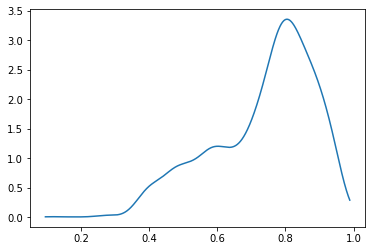

In [145]:
from scipy.stats import gaussian_kde
i=0
kde1 = gaussian_kde(undp_reduced.iloc[:, i].dropna(), bw_method='scott')
x = np.linspace(undp_reduced.iloc[:, i].dropna().min(), undp_reduced.iloc[:, i].dropna().max(), num=1000)
plt.plot(x, kde1.pdf(x))
x[np.argmax(kde1.pdf(x))]

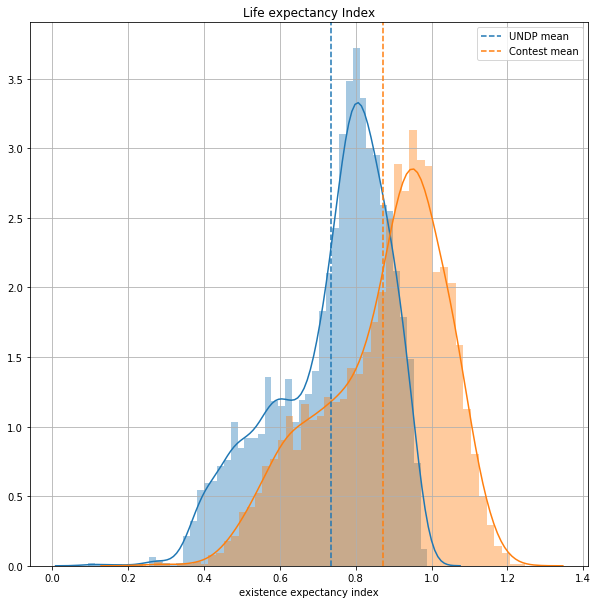

blue std = 0.150310507192437
blue mean = 0.7358885010665102
blue median = 0.774
blue min = 0.095
blue max = 0.989 

red std = 0.16279757508759315
red mean = 0.8723338332658475
red median = 0.9075385989202893
red min = 0.2278895010882802
red max = 1.2469083702468475


In [155]:
i = 0
colors = sns.color_palette()
plt.figure(figsize=(10,10))
# hist1 = plt.hist(undp_reduced.iloc[:, i], color='b', label='UNDP', bins=50)
# hist2 = plt.hist(data_train_cl_no_world.iloc[:, i], color='r', alpha=0.5, label='Contest', bins=50)
ax1 = sns.distplot(undp_reduced.iloc[:, i], bins = 50)
ax2 = sns.distplot(data_train_cl_no_world.iloc[:, i], bins= 50)

# peak1 = (hist1[1][np.argmax(hist1[0])]
#          + hist1[1][np.argmax(hist1[0])+1])/2
# peak2 = (hist2[1][np.argmax(hist2[0])]
#          + hist2[1][np.argmax(hist2[0])+1])/2

# max1 = np.nanpercentile(undp_reduced.iloc[:, i], 100)
# max2 = np.nanpercentile(data_train_cl_no_world.iloc[:, i].max(), 100)

# k = (peak2 - max2) / (peak1 - max1)
# c = peak2 - peak1*k

# plt.axvline(x=peak1, color='b', ls='-')
# plt.axvline(x=peak2, color='r', ls='-')

# plt.hist(k*undp_reduced.iloc[:, i] + c, alpha=0.5, color='c', label='Shifted UNDP', bins=50)
plt.axvline(x=undp_reduced.iloc[:, i].mean(), color=colors[0], ls='--', label='UNDP mean')
plt.axvline(x=data_train_cl_no_world.iloc[:, i].mean(), color=colors[1], ls='--', label='Contest mean')
#plt.axvline(x=(undp_reduced.iloc[:, i] + 0.2*undp_reduced.iloc[:, i].median()).median(), color='y', ls='--')

plt.grid()
plt.title(undp_reduced.columns[i])
plt.legend()
plt.show()
# print('k =', k)
# print('c =', c)

print('blue std =', np.std(undp_reduced.iloc[:, i]))
print('blue mean =', undp_reduced.iloc[:, i].mean())
print('blue median =', undp_reduced.iloc[:, i].median())
print('blue min =', undp_reduced.iloc[:, i].min())
print('blue max =', undp_reduced.iloc[:, i].max(), '\n')

print('red std =', np.std(data_train_cl_no_world.iloc[:, i]))
print('red mean =', data_train_cl_no_world.iloc[:, i].mean())
print('red median =', data_train_cl_no_world.iloc[:, i].median())
print('red min =', data_train_cl_no_world.iloc[:, i].min())
print('red max =', data_train_cl_no_world.iloc[:, i].max())

